# Entrenamiento cnn-gru

In [302]:
import re
from pathlib import Path

def _extract_num(s: str) -> int:
    m = re.search(r'(\d+)', s)
    return int(m.group(1)) if m else -1

def sorted_frames(folder: Path):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
    imgs = [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in exts]
    return sorted(imgs, key=lambda p: _extract_num(p.stem))

In [303]:
def get_ball_center(gray_img: np.ndarray):
    """Retorna (cx, cy, area) del blob blanco; None si no hay blob."""
    _, binim = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)
    M = cv2.moments(binim)
    if M["m00"] == 0:
        return None
    cx = M["m10"] / M["m00"]
    cy = M["m01"] / M["m00"]
    area = M["m00"] / 255.0
    return float(cx), float(cy), float(area)

def sorted_frames_old(folder: Path):
    """Lista de paths ordenados alfabéticamente (asume nombres con orden temporal)."""
    imgs = sorted([p for p in folder.glob("*.jpg")])
    return imgs

import re

def _extract_num(s: str) -> int:
    """
    Extrae el primer número del nombre (p.ej. 'img_12.jpg' -> 12).
    Si no hay número, devuelve -1 para que queden primero (ajústalo si prefieres al final).
    """
    m = re.search(r'(\d+)', s)
    return int(m.group(1)) if m else -1

def sorted_frames(folder: Path):
    """
    Lista de paths ordenados por índice numérico en el nombre del archivo.
    Ej.: 1.jpg, 2.jpg, 10.jpg -> 1, 2, 10
    """
    imgs = [p for p in folder.iterdir()
            if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png"}]
    return sorted(imgs, key=lambda p: _extract_num(p.stem))

def load_launch_sequences(base_dir: str, min_len: int = 1):
    base = Path(base_dir)
    launch_dirs = [d for d in base.iterdir() if d.is_dir()]
    sequences = {}
    width = height = None

    empty_ids = []   
    short_ids = [] 

    for d in sorted(launch_dirs):
        frames = sorted_frames(d)
        seq = []
        for fp in frames:
            img = cv2.imread(str(fp), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            h, w = img.shape
            if height is None: height, width = h, w
            c = get_ball_center(img)
            if c is not None:
                seq.append(c)  

        arr = np.array(seq, dtype=np.float32).reshape(-1, 3) 
        if arr.shape[0] == 0:
            empty_ids.append(d.name)
            continue  

        if arr.shape[0] < min_len:
            short_ids.append((d.name, arr.shape[0]))

        sequences[d.name] = arr

    print(f"Secuencias cargadas: {len(sequences)}  | Vacías: {len(empty_ids)}  | <{min_len}: {len(short_ids)}")
    if empty_ids:
        print("IDs vacíos (sin detecciones):", empty_ids[:10], "..." if len(empty_ids) > 10 else "")
    if short_ids:
        print("IDs cortos:", short_ids[:10], "..." if len(short_ids) > 10 else "")
    return sequences, width, height

DATA_DIR = "fotos_binarizadas_limpias"

sequences_raw, W, H = load_launch_sequences(DATA_DIR)
print(f"Lanzamientos válidos: {len(sequences_raw)}  | Tamaño imagen: {W}x{H}")

Secuencias cargadas: 1199  | Vacías: 0  | <1: 0
Lanzamientos válidos: 1199  | Tamaño imagen: 640x480


# Dataset de ventanas con imágenes (X) y posiciones (Y)

In [304]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

class BallFramesDataset_old(Dataset):
    """
    Devuelve:
      X: [T_in, 1, H_in, W_in]  (grayscale normalizado 0..1)
      Y: [T_out, 2]             (posiciones normalizadas)
    """
    def __init__(self, base_dir: str, seqs_dict, ids, T_in=6, T_out=6,
                 in_size=(64, 64), img_mode=cv2.IMREAD_GRAYSCALE):
        self.samples = []  # lista de (frames_paths_window, Y_window_norm)
        self.in_size = in_size
        self.img_mode = img_mode
        base = Path(base_dir)
        self.W_img = None
        self.H_img = None

        for lid in ids:
            d = base / lid
            frames = sorted_frames(d)
            if len(frames) == 0: 
                continue
            # dimensiones originales (de la primera imagen válida)
            if self.W_img is None or self.H_img is None:
                test_img = cv2.imread(str(frames[0]), img_mode)
                self.H_img, self.W_img = test_img.shape[:2]

            seq = seqs_dict[lid]  # [T, 3] (cx, cy, area) en pixeles
            T = len(seq)
            # Ventanas deslizantes: sincronizamos con frames por índice
            # Suponemos correspondencia 1:1 en orden (ya corregido el sorting)
            usable = min(T, len(frames))
            for t in range(usable - T_in - T_out + 1):
                xwin_paths = frames[t : t+T_in]
                # Y: normalizamos x,y
                sub = seq[t+T_in : t+T_in+T_out, :2].astype(np.float32)
                sub[:, 0] = sub[:, 0] / self.W_img      # x_norm
                sub[:, 1] = 1.0 - (sub[:, 1] / self.H_img)  # y_norm invertido
                self.samples.append((xwin_paths, sub))

    def __len__(self): 
        return len(self.samples)

    def _load_stack(self, paths):
        H_in, W_in = self.in_size
        stack = []
        for p in paths:
            img = cv2.imread(str(p), self.img_mode)
            if img is None:
                # frame faltante → imagen negra
                img = np.zeros((self.H_img, self.W_img), dtype=np.uint8)
            if img.ndim == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (W_in, H_in), interpolation=cv2.INTER_AREA)
            img = img.astype(np.float32) / 255.0
            stack.append(img[None, ...])  # [1, H, W]
        x = np.stack(stack, axis=0)  # [T_in, 1, H, W]
        return x

    def __getitem__(self, i):
        paths, y = self.samples[i]
        x = self._load_stack(paths)
        return torch.from_numpy(x), torch.from_numpy(y)

In [305]:
import cv2
import torch
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset

def sorted_frames(d: Path):
    return sorted([p for p in d.iterdir() if p.is_file()])

class BallFramesDataset(Dataset):
    """
    Devuelve:
      X: [T_in, 1, H_in, W_in]        (frames de entrada)
      Y: [T_out, 2]                   (futuro real normalizado con y hacia ARRIBA)
      H: [T_in, 2]                    (historial normalizado con y hacia ARRIBA)
    """
    def __init__(self, base_dir: str, seqs_dict, ids, T_in=6, T_out=6,
                 in_size=(64, 64), img_mode=cv2.IMREAD_GRAYSCALE):
        self.samples = []
        self.in_size = in_size
        self.img_mode = img_mode
        base = Path(base_dir)
        self.W_img = None
        self.H_img = None

        for lid in ids:
            d = base / lid
            frames = sorted_frames(d)
            if len(frames) == 0: 
                continue

            # fija W,H con primer frame legible
            if self.W_img is None or self.H_img is None:
                for p in frames:
                    im = cv2.imread(str(p), img_mode)
                    if im is not None:
                        if im.ndim == 3:
                            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                        self.H_img, self.W_img = im.shape[:2]
                        break

            seq = seqs_dict.get(lid, None)  # [T,3] (cx,cy,area) en píxeles
            if seq is None or len(seq) == 0:
                continue

            usable = min(len(seq), len(frames))
            if usable - T_in - T_out + 1 <= 0:
                continue

            for t in range(usable - T_in - T_out + 1):
                xwin_paths = frames[t : t+T_in]

                # HISTORIAL normalizado [T_in,2]
                hxy = seq[t : t+T_in, :2].astype(np.float32).copy()
                hxy[:, 0] = hxy[:, 0] / self.W_img
                hxy[:, 1] = 1.0 - (hxy[:, 1] / self.H_img)

                # 🚀 Aquí añadimos features adicionales
                xy = hxy                                # [T_in,2]
                vel = np.diff(xy, axis=0, prepend=xy[:1])   # Δx, Δy

                if seq.shape[1] > 2:  # si tienes el área en la tercera columna
                    area = (seq[t:t+T_in, 2] / (self.W_img*self.H_img)).astype(np.float32)[:,None]
                    H_feat = np.concatenate([xy, vel, area], axis=1)   # [T_in,5]
                else:
                    H_feat = np.concatenate([xy, vel], axis=1)         # [T_in,4]

                # FUTURO normalizado [T_out,2]
                yxy = seq[t+T_in : t+T_in+T_out, :2].astype(np.float32).copy()
                yxy[:, 0] = yxy[:, 0] / self.W_img
                yxy[:, 1] = 1.0 - (yxy[:, 1] / self.H_img)

                #self.samples.append((xwin_paths, yxy, hxy))
                self.samples.append((xwin_paths, yxy, H_feat))

        if len(self.samples) == 0:
            raise RuntimeError("BallFramesDataset quedó vacío. Verifica DATA_DIR/ids/T_in/T_out.")

    def _load_stack(self, paths):
        H_in, W_in = self.in_size
        stack = []
        for p in paths:
            img = cv2.imread(str(p), self.img_mode)
            if img is None:
                img = np.zeros((self.H_img, self.W_img), dtype=np.uint8)
            elif img.ndim == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (W_in, H_in), interpolation=cv2.INTER_AREA)
            img = img.astype(np.float32) / 255.0
            stack.append(img[None, ...])  # [1,H,W]
        return np.stack(stack, axis=0)  # [T_in,1,H,W]

    def __len__(self): 
        return len(self.samples)

    def __getitem__(self, i):
        paths, yxy, H_feat = self.samples[i]
        x = self._load_stack(paths)
        return (
            torch.from_numpy(x),   # X: [T_in,1,H,W]
            torch.from_numpy(yxy), # Y: [T_out,2] (y invertida)
            torch.from_numpy(H_feat), # H: [T_in,2]  (y invertida)
        )

# LightningModule: CNN encoder → GRU → head
	•	CNN sencilla (3 bloques Conv-BN-ReLU + GAP) → embedding E
	•	Procesamiento time-distributed: (B*T, 1, H, W) → (B, T, E)
	•	GRU → mean+max pooling temporal → head a 2*T_out
	•	Pérdida con peso al final + suavidad (vel/acc)
	•	Métricas: ADE/FDE + Hit@r + AngErr

In [306]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L

class CNNEncoder(nn.Module):
    def __init__(self, emb_dim=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(2),  # 64->32
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),  # 32->16
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # GAP -> [B,64,1,1]
        )
        self.proj = nn.Linear(64, emb_dim)

    def forward(self, x):  # x: [B*T, 1, H, W]
        z = self.conv(x).flatten(1)  # [B*T, 64]
        z = self.proj(z)             # [B*T, emb_dim]
        return z

class GRUVis(L.LightningModule):
    def __init__(self, T_out=6, emb_dim=64, hidden=64, num_layers=2, lr=1e-3, lambda_v=0.1, hit_radius=0.02,H_feat_dim=5):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = CNNEncoder(emb_dim=emb_dim)
        #self.h_proj  = nn.Linear(2, 16)                # <— proyecta (x,y) del historial
        self.h_proj = nn.Linear(H_feat_dim, 16)

        self.gru     = nn.GRU(input_size=emb_dim+16,   # <— concat e y h_emb
                              hidden_size=hidden, num_layers=num_layers,
                              dropout=0.2, batch_first=True)
        self.head    = nn.Linear(hidden, 2*self.hparams.T_out)

        self.delta_head = nn.Linear(hidden, 2*self.hparams.T_out)


    # ===== métricas auxiliares =====
    @torch.no_grad()
    def _ade_fde(self, yhat, y):
        err = torch.linalg.vector_norm(yhat - y, dim=-1)  # [B,T_out]
        return err.mean(), err[:, -1].mean()

    @torch.no_grad()
    def _hit_rate(self, yhat, y, radius=None, final_only=True):
        if radius is None: radius = self.hparams.hit_radius
        diff = torch.linalg.vector_norm(yhat - y, dim=-1)
        if final_only:
            return (diff[:, -1] <= radius).float().mean()
        else:
            return (diff <= radius).float().mean()

    @torch.no_grad()
    def _angular_error_deg(self, yhat, y, mode="final"):
        eps = 1e-8
        if mode == "final":
            vhat = yhat[:, -1] - yhat[:, 0]
            v    = y[:, -1]    - y[:, 0]
            dot = (vhat*v).sum(-1)
            n1  = torch.linalg.vector_norm(vhat, dim=-1).clamp_min(eps)
            n2  = torch.linalg.vector_norm(v,    dim=-1).clamp_min(eps)
            cos = (dot / (n1*n2)).clamp(-1+1e-6, 1-1e-6)
            ang = torch.rad2deg(torch.arccos(cos))
            return ang.mean()
        else:
            vhat = yhat[:,1:] - yhat[:,:-1]
            v    = y[:,1:]    - y[:,:-1]
            dot = (vhat*v).sum(-1)
            n1  = torch.linalg.vector_norm(vhat, dim=-1).clamp_min(eps)
            n2  = torch.linalg.vector_norm(v,    dim=-1).clamp_min(eps)
            cos = (dot / (n1*n2)).clamp(-1+1e-6, 1-1e-6)
            ang = torch.rad2deg(torch.arccos(cos))
            return ang.mean()

    # ===== forward =====
    def forward(self, x, h=None):
        B, T, C, H, W = x.shape
        e = self.encoder(x.view(B*T, C, H, W)).view(B, T, -1)

        if h is None:
            # si no llega h, rellena para mantener dims
            h_emb = torch.zeros(B, T, 16, device=e.device, dtype=e.dtype)
            y0_xy = torch.zeros(B, 2, device=e.device, dtype=e.dtype)
        else:
            # h puede tener 2, 4 o 5 cols -> proyecta todo para features...
            h_emb = torch.relu(self.h_proj(h))                   # [B,T,16]
            # ...pero para el anclaje usa SOLO (x,y)
            y0_xy = h[..., :2][:, -1, :]                         # [B,2]

        e = torch.cat([e, h_emb], dim=-1)                        # [B,T, emb_dim+16]
        out, _ = self.gru(e)
        z = 0.5*(out.mean(1) + out.max(1).values)                # [B,hidden]

        deltas = self.delta_head(z).view(B, self.hparams.T_out, 2)  # [B,T_out,2]
        yhat = y0_xy.unsqueeze(1) + torch.cumsum(deltas, dim=1)     # ✅ [B,T_out,2]
        return yhat

    # ===== pérdida =====
    def _loss_old(self, yhat, y):
        # 1) Peso al final (FDE)
        per_step = F.mse_loss(yhat, y, reduction="none").mean(dim=-1)  # [B,T_out]
        weights = torch.linspace(0.8, 2.5, steps=self.hparams.T_out, device=y.device)
        loss_pos = (per_step*weights).mean()

        # 2) Suavidad 1ª derivada
        dv_hat = yhat[:,1:] - yhat[:,:-1]
        dv     = y[:,1:]    - y[:,:-1]
        loss_vel = F.mse_loss(dv_hat, dv)

        # 3) Suavidad 2ª derivada
        if self.hparams.T_out > 2:
            dda_hat = yhat[:,2:] - 2*yhat[:,1:-1] + yhat[:,:-2]
            dda     = y[:,2:]    - 2*y[:,1:-1]    + y[:,:-2]
            loss_acc = F.mse_loss(dda_hat, dda)
        else:
            loss_acc = 0.0

        return loss_pos + self.hparams.lambda_v*loss_vel + 0.05*loss_acc

    def _loss(self, yhat, y):
        per_step = F.smooth_l1_loss(yhat, y, reduction="none").mean(dim=-1)
        w = torch.linspace(0.8, 3.0, steps=self.hparams.T_out, device=y.device)
        loss_pos = (per_step*w).mean()

        dv_hat = yhat[:,1:] - yhat[:,:-1]; dv = y[:,1:] - y[:,:-1]
        loss_vel = F.smooth_l1_loss(dv_hat, dv)

        if self.hparams.T_out > 2:
            dda_hat = yhat[:,2:] - 2*yhat[:,1:-1] + yhat[:,:-2]
            dda     = y[:,2:]    - 2*y[:,1:-1]    + y[:,:-2]
            loss_acc = F.smooth_l1_loss(dda_hat, dda)
        else:
            loss_acc = 0.0

        return loss_pos + self.hparams.lambda_v*loss_vel + 0.05*loss_acc

    def training_step(self, batch, _):
        x, y, h = self._unpack_batch(batch)
        yhat = self(x, h)                    
        loss = self._loss(yhat, y)
        ade, fde = self._ade_fde(yhat, y)
        self.log_dict({"train/loss": loss, "train/ADE": ade, "train/FDE": fde}, prog_bar=True)
        return loss

    def validation_step(self, batch, _):
        x, y, h = self._unpack_batch(batch)
        yhat = self(x, h)                   
        loss = self._loss(yhat, y)
        ade, fde = self._ade_fde(yhat, y)
        self.log_dict({"val/loss": loss, "val/ADE": ade, "val/FDE": fde}, prog_bar=True)

    def test_step(self, batch, _):
        x, y, h = self._unpack_batch(batch)
        yhat = self(x, h)                   
        loss = self._loss(yhat, y)
        ade, fde = self._ade_fde(yhat, y)
        self.log_dict({"test/loss": loss, "test/ADE": ade, "test/FDE": fde}, prog_bar=True)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", patience=5, factor=0.5)
        return {"optimizer": opt, "lr_scheduler": {"scheduler": sch, "monitor": "val/loss"}}

    def _unpack_batch(self, batch):
        """Permite (X,Y) o (X,Y,H)."""
        if isinstance(batch, (list, tuple)):
            if len(batch) == 3:
                x, y, h = batch
            elif len(batch) == 2:
                x, y = batch
                h = None
            else:
                raise ValueError(f"Batch inesperado con {len(batch)} elementos")
        else:
            raise ValueError("Batch debe ser tuple/list")
        return x, y, h

In [307]:
from torch.utils.data import DataLoader
import lightning as L

class FramesDataModule(L.LightningDataModule):
    def __init__(self, base_dir, seqs, train_ids, val_ids, test_ids,
                 T_in, T_out, batch_size=32, num_workers=4, in_size=(64,64)):
        super().__init__()
        self.base_dir = base_dir
        self.seqs = seqs
        self.train_ids = train_ids
        self.val_ids = val_ids
        self.test_ids = test_ids
        self.T_in = T_in; self.T_out = T_out
        self.bs = batch_size
        self.nw = num_workers
        self.in_size = in_size

    def setup(self, stage=None):
        self.train_ds = BallFramesDataset(self.base_dir, self.seqs, self.train_ids,
                                          T_in=self.T_in, T_out=self.T_out, in_size=self.in_size)
        self.val_ds   = BallFramesDataset(self.base_dir, self.seqs, self.val_ids,
                                          T_in=self.T_in, T_out=self.T_out, in_size=self.in_size)
        self.test_ds  = BallFramesDataset(self.base_dir, self.seqs, self.test_ids,
                                          T_in=self.T_in, T_out=self.T_out, in_size=self.in_size)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.bs, shuffle=True, num_workers=self.nw, pin_memory=True)
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.bs, shuffle=False, num_workers=self.nw, pin_memory=True)
    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.bs, shuffle=False, num_workers=self.nw, pin_memory=True)

# Split

In [308]:
import random

all_ids = sorted(list(sequences_raw.keys()))
random.shuffle(all_ids)

n = len(all_ids)
n_train = int(0.7 * n)
n_val   = int(0.20 * n)

train_ids = all_ids[:n_train]
val_ids   = all_ids[n_train:n_train+n_val]
test_ids  = all_ids[n_train+n_val:]

print("Split por lanzamiento:")
print("Train:", len(train_ids), "Val:", len(val_ids), "Test:", len(test_ids))

Split por lanzamiento:
Train: 839 Val: 239 Test: 121


In [309]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger

T_IN, T_OUT = 6, 6
BATCH = 32
NUM_WORKERS = 0
IN_SIZE = (64, 64)
LR = 1e-3
DATA_DIR = "fotos_binarizadas_limpias"

dm_frames = FramesDataModule(
    base_dir=DATA_DIR, seqs=sequences_raw,
    train_ids=train_ids, val_ids=val_ids, test_ids=test_ids,
    T_in=T_IN, T_out=T_OUT, batch_size=BATCH, num_workers=NUM_WORKERS,
    in_size=IN_SIZE
)

modelB = GRUVis(T_out=T_OUT, emb_dim=64, hidden=64, num_layers=1, lr=LR, lambda_v=0.1, hit_radius=0.02)

logger = CSVLogger("lightning_logs", name="ball_gru_img")
callbacks = [
    EarlyStopping(monitor="val/loss", mode="min", patience=10),
    ModelCheckpoint(monitor="val/loss", mode="min", save_top_k=2),
    LearningRateMonitor(logging_interval="epoch"),
]

trainer = L.Trainer(
    max_epochs=60,
    logger=logger,
    callbacks=callbacks,
    deterministic=True,
    gradient_clip_val=1.0,
)

trainer.fit(modelB, datamodule=dm_frames)
trainer.test(modelB, datamodule=dm_frames)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | CNNEncoder | 27.7 K
1 | h_proj     | Linear     | 96    
2 | gru        | GRU        | 28.0 K
3 | head       | Linear     | 780   
4 | delta_head | Linear     | 780   
------------------------------------------
57.4 K    Trainable params
0         Non-trainable params
57.4 K    Total params
0.229     Total estimated model params size (MB)


/Users/slincastro/.pyenv/versions/3.11.7/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/slincastro/.pyenv/versions/3.11.7/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 20: 100%|██████████| 13/13 [00:01<00:00,  8.13it/s, v_num=23, train/loss=0.0132, train/ADE=0.105, train/FDE=0.197, val/loss=0.0185, val/ADE=0.126, val/FDE=0.253] 


/Users/slincastro/.pyenv/versions/3.11.7/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 16.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/ADE          │    0.11203490942716599    │
│         test/FDE          │    0.22866182029247284    │
│         test/loss         │   0.015181626193225384    │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.015181626193225384,
  'test/ADE': 0.11203490942716599,
  'test/FDE': 0.22866182029247284}]

# Gráfico: Loss / ADE / FDE

📂 Usando logs de: lightning_logs/ball_gru_img/version_23


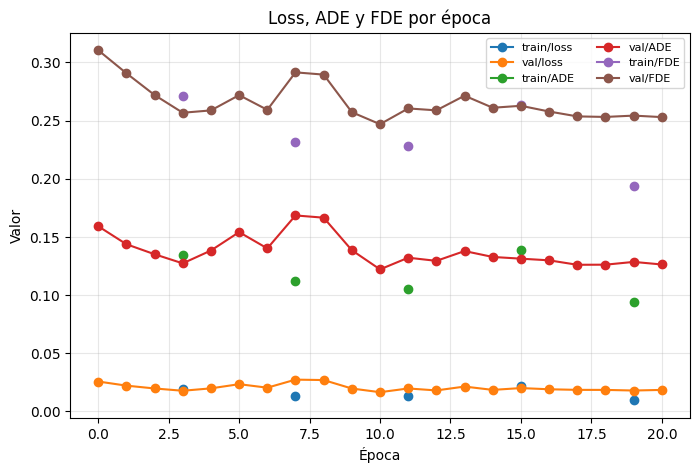

In [310]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

base_dir = Path("lightning_logs/ball_gru_img")
versions = sorted(
    [d for d in base_dir.iterdir() if d.is_dir() and d.name.startswith("version_")],
    key=lambda d: int(d.name.split("_")[-1])
)
assert versions, "No se encontraron versiones en lightning_logs/ball_gru_img"
log_dir = versions[-1]
print(f"📂 Usando logs de: {log_dir}")

df = pd.read_csv(log_dir / "metrics.csv")
df_e = df.dropna(subset=["epoch"]).groupby("epoch", as_index=False).last()

def pick_col(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

train_loss = pick_col(df_e.columns, ["train/loss", "train/loss_epoch"])
val_loss   = pick_col(df_e.columns, ["val/loss", "val/loss_epoch"])
plt.figure(figsize=(8,5))

if train_loss:
    plt.plot(df_e["epoch"], df_e[train_loss], marker="o", label=train_loss)
if val_loss:
    plt.plot(df_e["epoch"], df_e[val_loss], marker="o", label=val_loss)

for c in ["train/ADE", "val/ADE", "train/FDE", "val/FDE"]:
    if c in df_e.columns:
        plt.plot(df_e["epoch"], df_e[c], marker="o", label=c)

plt.title("Loss, ADE y FDE por época")
plt.xlabel("Época")
plt.ylabel("Valor")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=8)
plt.show()

In [311]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

@torch.no_grad()
def predict_batch_old(model, batch, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval().to(device)
    x, y = batch  # x:[B,T_in,1,H,W], y:[B,T_out,2] (normalizado)
    x = x.to(device)
    yhat = model(x)  # [B,T_out,2] normalizado
    return yhat.cpu(), y  # devolvemos en CPU para graficar

def plot_pred(y_true, y_pred, title=None, ax=None):
    """y_*: [T_out,2] en espacio normalizado con eje Y invertido (0 abajo, 1 arriba)."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4))
    ax.plot(y_true[:,0], y_true[:,1], '-o', label='GT', alpha=0.9)
    ax.plot(y_pred[:,0], y_pred[:,1], '-o', label='Pred', alpha=0.9)
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    #ax.invert_yaxis()  # opcional: si prefieres origen arriba, quita esta línea
    ax.invert_yaxis()
    ax.grid(True, ls="--", alpha=0.4)
    if title: ax.set_title(title)
    ax.legend()

def plot_grid(y_true_batch, y_pred_batch, rows=3, cols=4, start_idx=0):
    """Muestra una grilla de predicciones."""
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = np.array(axes).reshape(rows, cols)
    for i in range(rows*cols):
        if start_idx + i >= len(y_true_batch): break
        ax = axes[i//cols, i%cols]
        plot_pred(y_true_batch[start_idx+i], y_pred_batch[start_idx+i], 
                  title=f"Sample {start_idx+i}", ax=ax)
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def predict_batch_with_hist(model, batch, device=None):
    """
    batch = (X, Y, H)
    Retorna yhat, y, h en CPU para graficar.
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval().to(device)

    x, y, h = batch
    x, h = x.to(device), h.to(device)
    yhat = model(x, h)   # 👈 pasa h al forward

    return yhat.cpu(), y.cpu(), h.cpu()


def plot_sample(h, y, yhat, title=None, ax=None):
    """
    h:   [T_in,2]  historial
    y:   [T_out,2] futuro real (GT)
    yhat:[T_out,2] predicción
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4))
    ax.plot(h[:,0],   h[:,1],   '-o', label='Historial (T_in)')
    ax.plot(y[:,0],   y[:,1],   '-x', label='Futuro real (T_out)')
    ax.plot(yhat[:,0],yhat[:,1],'-o', label='Predicción (T_out)')
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.invert_yaxis()  # quítalo si quieres ver en coordenadas cartesiano (y arriba)
    ax.grid(True, ls='--', alpha=0.4)
    if title: ax.set_title(title)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.legend()


def plot_grid_hist(y_batch, yhat_batch, h_batch, rows=3, cols=4, start=0):
    import numpy as np
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = np.array(axes).reshape(rows, cols)
    for i in range(rows*cols):
        idx = start + i
        if idx >= len(y_batch): break
        plot_sample(h_batch[idx].numpy(), 
                    y_batch[idx].numpy(), 
                    yhat_batch[idx].numpy(),
                    title=f"Sample {idx}", 
                    ax=axes[i//cols, i%cols])
    plt.tight_layout()
    plt.show()

/Users/slincastro/.pyenv/versions/3.11.7/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


<Figure size 600x400 with 0 Axes>

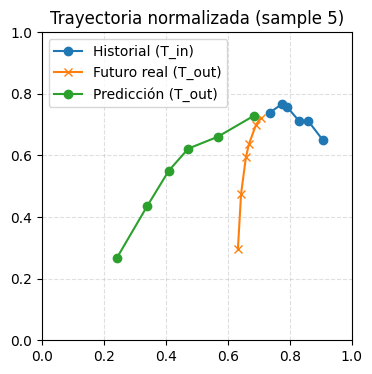

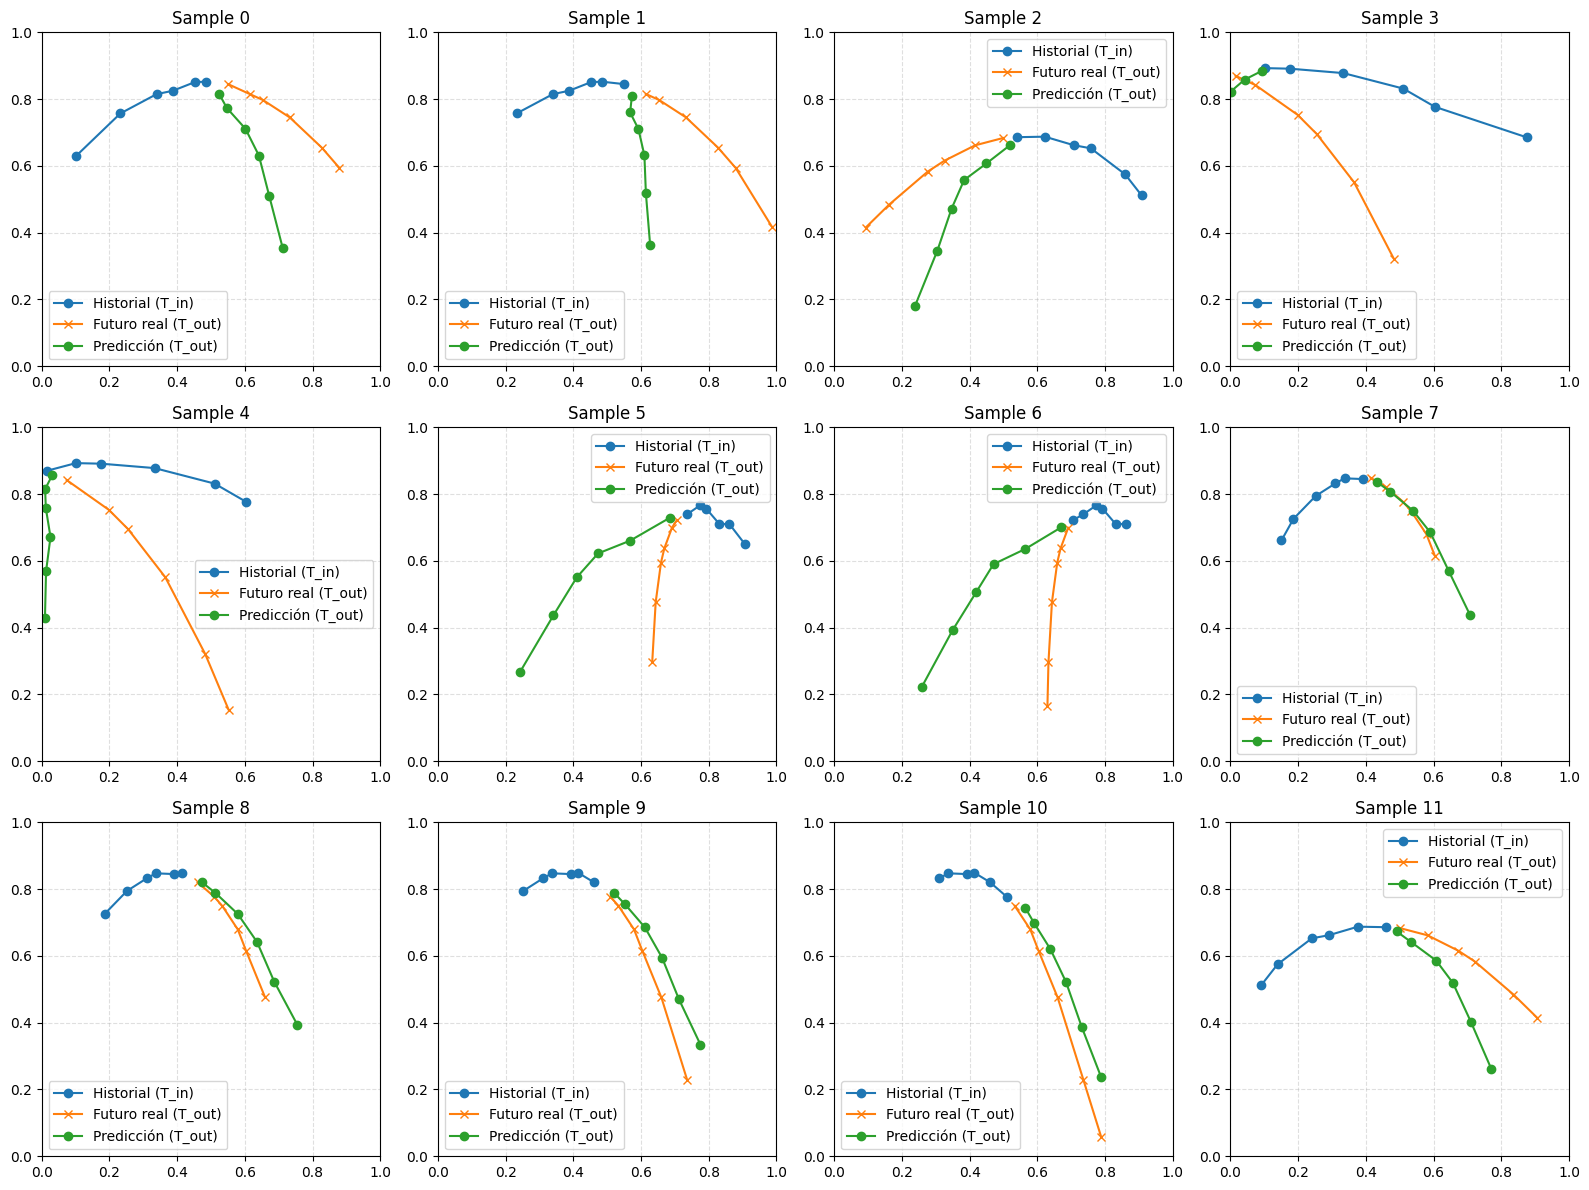

In [312]:
dm_frames.setup()
val_loader = dm_frames.val_dataloader()

batch = next(iter(val_loader))  

yhat, y, h = predict_batch_with_hist(modelB, batch)

idx = 5
plt.figure(figsize=(6,4))
plot_sample(h[idx].numpy(), y[idx].numpy(), yhat[idx].numpy(),
            title=f"Trayectoria normalizada (sample {idx})")
plt.show()

plot_grid_hist(y, yhat, h, rows=3, cols=4, start=0)

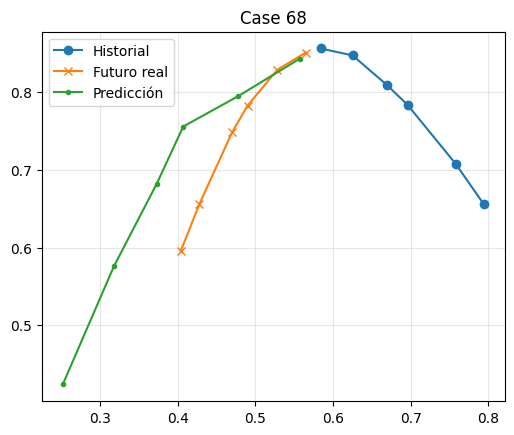

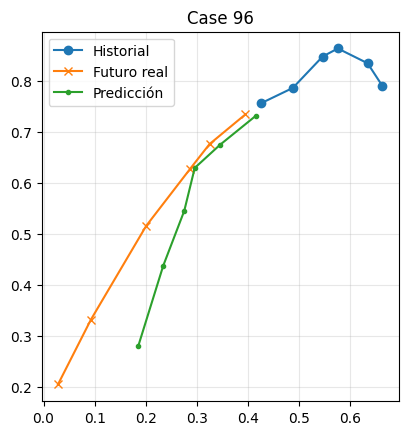

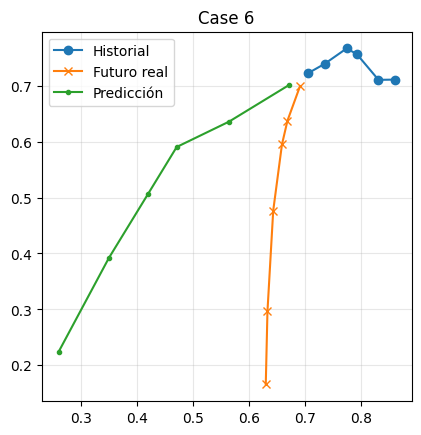

In [313]:
@torch.no_grad()
def visualize_random_case(model, dataset, k=3):
    model.eval()
    idxs = random.sample(range(len(dataset)), k=min(k, len(dataset)))
    for i in idxs:
        X, Y, H = dataset[i]
        Xb = X.unsqueeze(0).to(model.device)
        Hb = H.unsqueeze(0).to(model.device)

        Yhat = model(Xb, Hb).squeeze(0).cpu()

        plt.figure()
        plt.plot(H[:,0], H[:,1], marker="o", label="Historial")
        plt.plot(Y[:,0], Y[:,1], marker="x", label="Futuro real")
        plt.plot(Yhat[:,0], Yhat[:,1], marker=".", label="Predicción")
        plt.gca().set_aspect("equal", adjustable="box")
        plt.grid(True, alpha=0.3); plt.legend()
        plt.title(f"Case {i}")
        plt.show()

visualize_random_case(modelB, dm_frames.val_dataloader().dataset, k=3)

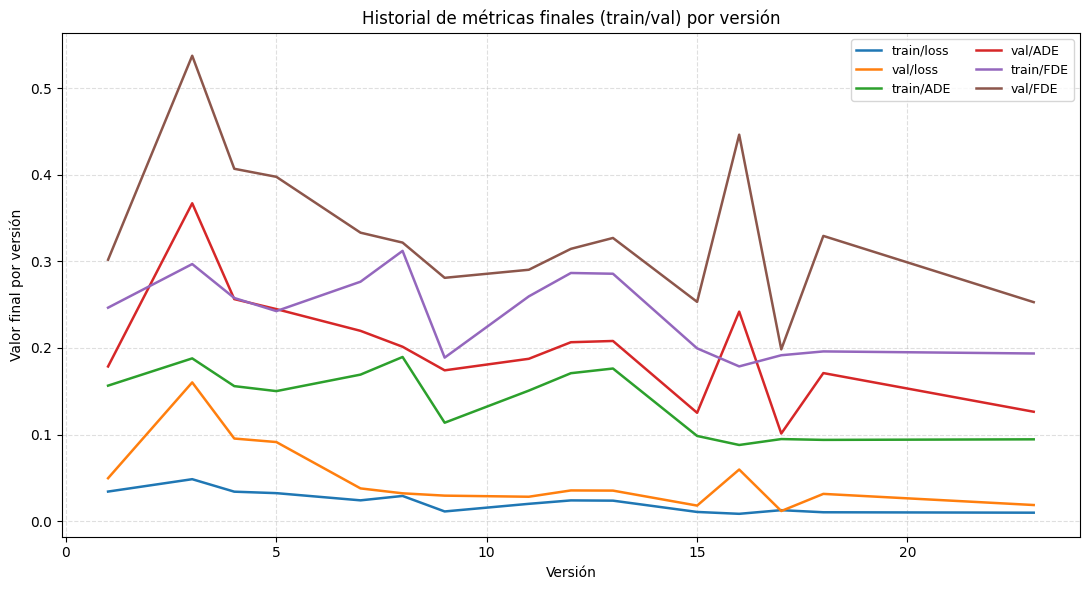

In [314]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base_dir = Path("lightning_logs/ball_gru_img")

metrics_wanted = [
    "train/loss", "val/loss",
    "train/ADE",  "val/ADE",
    "train/FDE",  "val/FDE",
    # "train/Hit@0.02", "val/Hit@0.02",
    # "train/AngErr_deg", "val/AngErr_deg",
]

versions = sorted(
    [d for d in base_dir.iterdir() if d.is_dir() and d.name.startswith("version_")],
    key=lambda d: int(d.name.split("_")[-1])
)

def last_valid_by_epoch(df: pd.DataFrame, col: str):
    """Devuelve (epoch_max_con_valor, valor) para la métrica col."""
    if "epoch" not in df.columns or col not in df.columns:
        return np.nan, np.nan
    tmp = df[["epoch", col]].dropna(subset=["epoch", col])
    if tmp.empty:
        return np.nan, np.nan
    emax = tmp["epoch"].max()
    val  = tmp.loc[tmp["epoch"] == emax, col].iloc[-1]
    return emax, val

rows = []
for v in versions:
    csv = v / "metrics.csv"
    if not csv.exists():
        continue
    df = pd.read_csv(csv)
    rec = {"version": int(v.name.split("_")[-1])}
    for m in metrics_wanted:
        _, val = last_valid_by_epoch(df, m)
        rec[m] = pd.to_numeric(val, errors="coerce")
    if any(pd.notna(rec[m]) for m in metrics_wanted):
        rows.append(rec)

if not rows:
    print("⚠️ No hay métricas finales válidas en ninguna versión.")
else:
    summary = pd.DataFrame(rows).sort_values("version").reset_index(drop=True)

    plt.figure(figsize=(11, 6))

    plotted_any = False
    for m in metrics_wanted:
        if m in summary.columns and summary[m].notna().any():
            plt.plot(summary["version"], summary[m], linewidth=1.8, label=m)  
            plotted_any = True

    if not plotted_any:
        print("⚠️ Ninguna de las métricas solicitadas tiene datos para graficar.")
    else:
        plt.xlabel("Versión")
        plt.ylabel("Valor final por versión")
        plt.title("Historial de métricas finales (train/val) por versión")
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.legend(ncol=2, fontsize=9)
        plt.tight_layout()
        plt.show()
